<h1 align=center><font size = 5>Swin Transformer</h1 >


<h3>Objective for this Notebook</h3>
<h5> 1. 觀看架構圖，試著撰寫出模型的部分功能</h5>
<hr>

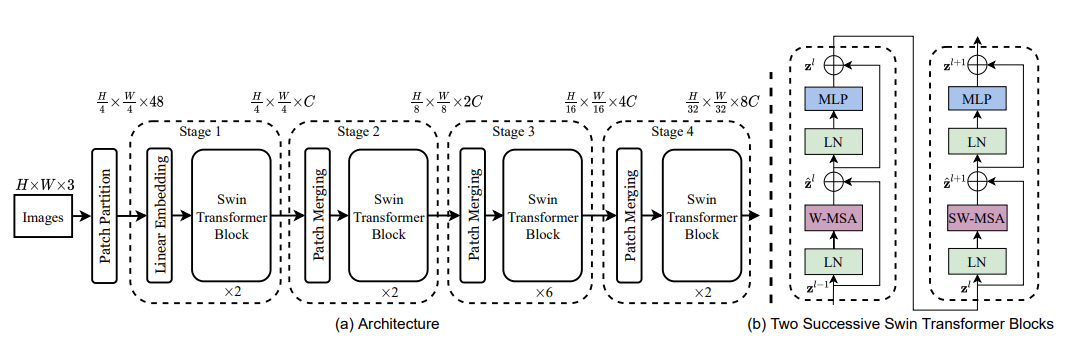

Swin Transformer的架構較為複雜，想要搞懂細節的同學建議去閱讀(讀書報告: 🔶 2-1. 圖像分類)中的實作範例

In [1]:
import torch
import torch.nn as nn
from einops import rearrange

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


In [19]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """





    return

def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """




    return


# 雙擊展開答案
<!--
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)

    return windows

def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)

    return x

如果使用einops套件來撰寫-----------

def window_partition(x, window_size):

    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = rearrange(x, 'b h ws1 w ws2 c -> (b h w) ws1 ws2 c', h=H // window_size, w=W // window_size)
    return windows

def window_reverse(windows, window_size, H, W):

    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = rearrange(
        windows,
        '(b h w) ws1 ws2 c -> b (h ws1) (w ws2) c',
        b=B,
        h=H // window_size,
        w=W // window_size
    )
    return x


-->

In [ ]:
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # (Wh, Ww)
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

        # 相對位置偏移表
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))

        # 建立相對位置編碼 index（固定不學習）
        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size[0] - 1
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        self.register_buffer("relative_position_index", relative_coords.sum(-1))

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(N, N, -1).permute(2, 0, 1)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)

        attn = self.softmax(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        return x


In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.window_size = window_size
        self.shift_size = shift_size if min(input_resolution) > window_size else 0

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim, window_size=(window_size, window_size), num_heads=num_heads
        )

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(in_features=dim, hidden_features=dim * 4)

        # 建立 attention mask（僅在使用 SW-MSA 時才需要）
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))
            h_slices = (slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None))
            w_slices = (slice(0, -window_size), slice(-window_size, -shift_size), slice(-shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, window_size)
            mask_windows = mask_windows.view(-1, window_size * window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        x = x.view(B, H, W, C)

        # cyclic shift if needed
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

        x_windows = window_partition(x, self.window_size)  # (num_windows*B, window_size, window_size, C)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        # attention
        attn_windows = self.attn(x_windows, mask=self.attn_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        x = window_reverse(attn_windows, self.window_size, H, W)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))

        x = x.view(B, H * W, C)

        # 殘差 + FFN
        x = x + self.mlp(self.norm2(x + self.norm1(x)))
        return x


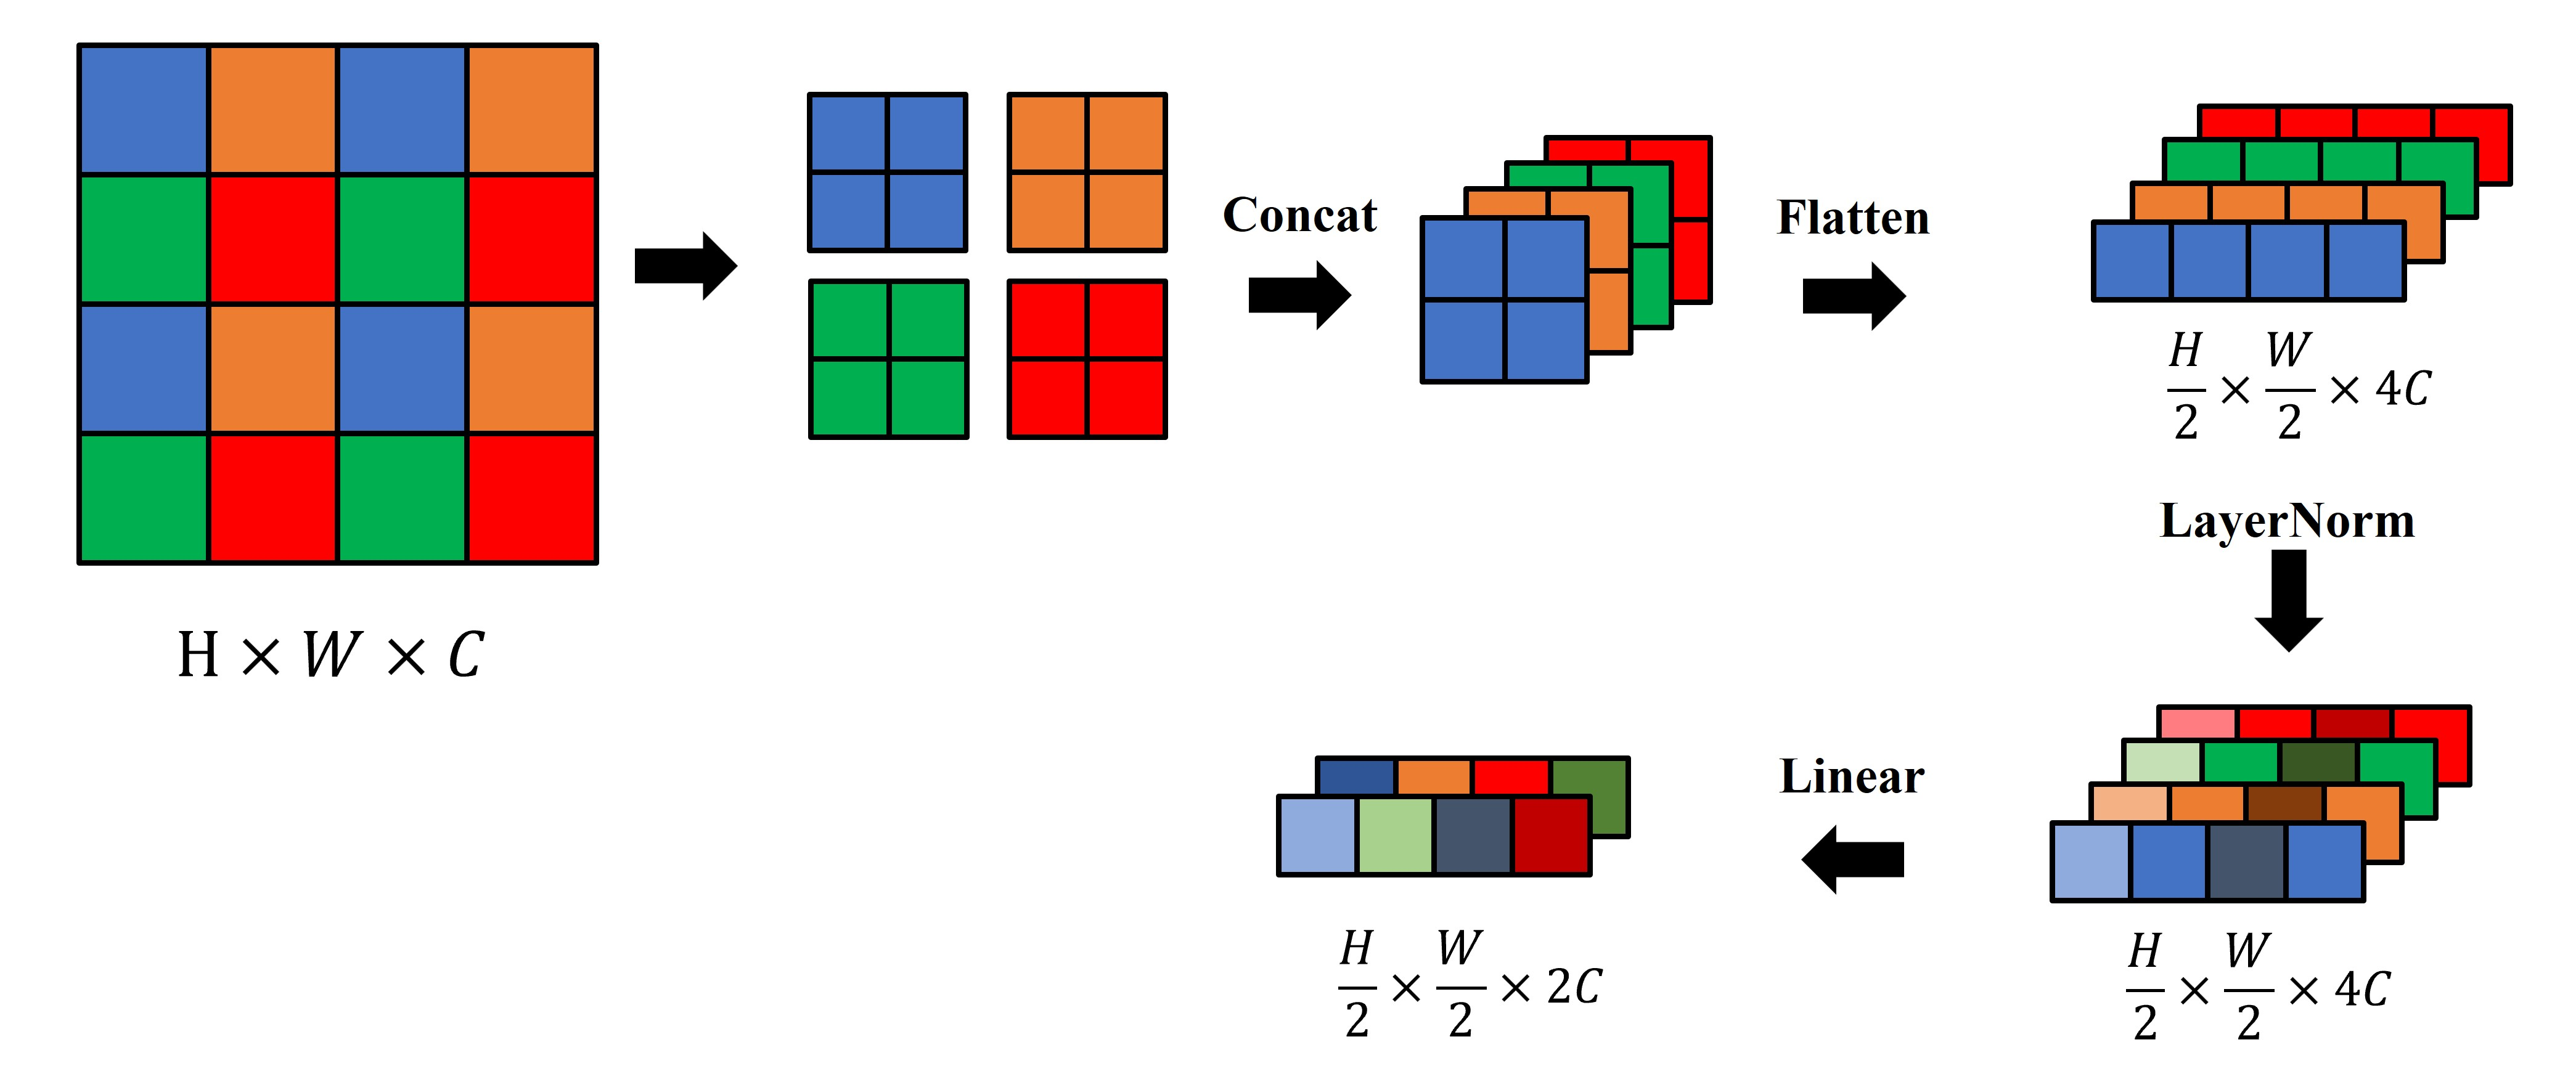

In [ ]:
class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim):
        super().__init__()






    def forward(self, x):





        return


# 雙擊展開答案
<!--

class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim):
        super().__init__()
        self.input_resolution = input_resolution
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = nn.LayerNorm(4 * dim)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # top-left
        x1 = x[:, 1::2, 0::2, :]  # bottom-left
        x2 = x[:, 0::2, 1::2, :]  # top-right
        x3 = x[:, 1::2, 1::2, :]  # bottom-right

        x = torch.cat([x0, x1, x2, x3], dim=-1)  # 拼接成 shape: (B, H/2, W/2, 4C)
        x = x.view(B, -1, 4 * C)  # 展平成 (B, H/2 * W/2, 4C)

        x = self.norm(x)
        x = self.reduction(x)
        return x
-->

In [ ]:
class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size, downsample=None):
        super().__init__()
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                dim=dim,
                input_resolution=input_resolution,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if i % 2 == 0 else window_size // 2
            )
            for i in range(depth)
        ])
        self.downsample = downsample(input_resolution, dim) if downsample else None

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        if self.downsample:
            x = self.downsample(x)
        return x


In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = (img_size // patch_size, img_size // patch_size)
        self.num_patches = self.patches_resolution[0] * self.patches_resolution[1]

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)                    # (B, C, H/4, W/4)
        x = x.flatten(2).transpose(1, 2)    # (B, N, C)
        x = self.norm(x)
        return x


In [ ]:
class SwinTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], window_size=7):
        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.num_features = embed_dim * (2 ** (self.num_layers - 1))

        # Patch embedding
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        patches_resolution = self.patch_embed.patches_resolution

        # Layers (Stages)
        self.layers = nn.ModuleList()
        for i in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i),
                input_resolution=(patches_resolution[0] // (2 ** i), patches_resolution[1] // (2 ** i)),
                depth=depths[i],
                num_heads=num_heads[i],
                window_size=window_size,
                downsample=PatchMerging if (i < self.num_layers - 1) else None
            )
            self.layers.append(layer)

        self.norm = nn.LayerNorm(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)               # (B, N, C)
        x = x.transpose(1, 2)          # (B, C, N)
        x = self.avgpool(x)            # (B, C, 1)
        x = torch.flatten(x, 1)        # (B, C)
        x = self.head(x)               # (B, num_classes)
        return x
